# CIS 530 Fall 2020 Homework 4

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Matthew Scharf"
PENNKEY = "81364044"
RECITATION = "3"

---

In [ ]:
import math, random, collections, os, operator, re, unicodedata, numpy as np, pandas as pd

# Section 0: Preliminaries for generating Shakespeare

You do not need to modify these cells.

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    text = re.sub(r'[^A-Za-z\'\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

The `create_ngram_model` function creates and returns a new n-gram model trained on the city names found in the path file.

In [ ]:
def create_tree(model_class, path, n=2):
    model = model_class(n)
    with open(path, encoding='utf-8', errors='ignore') as f:
        text = f.read()
        text = preprocess_text(text)
        model.update(text)
    return model

The `create_ngram_model_lines` creates and returns a new n-gram model trained on the city names found in the path file.

In [ ]:
def create_tree_lines(model_class, path, n=2, class_label=''):
    model = model_class(n, class_label)
    with open(path, encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = preprocess_text(line)
            model.update(line)
    return model

Here is a corpus of Shakespeare:

In [ ]:
!wget http://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt

URL transformed to HTTPS due to an HSTS policy
--2020-11-10 00:36:10--  https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4573338 (4.4M) [text/plain]
Saving to: ‘shakespeare_input.txt.1’

shakespeare_input.t 100%[===================>]   4.36M  3.64MB/s    in 1.2s    

2020-11-10 00:36:12 (3.64 MB/s) - ‘shakespeare_input.txt.1’ saved [4573338/4573338]



# Section 1: Generating Shakespeare

In this section, you will build a simple n-gram language model that can be used to generate random text resembling a source document. Your use of external code should be limited to built-in Python modules, which excludes, for example, NumPy and NLTK.

## **Section 1.1: TODO make CountTree class**

Write a basic `CountTree` class that stores ngrams observed in training data.

1.   Write an initialization method `__init__(self, n=2, class_label='')` which stores the order n of the model and initializes any necessary internal variables. 

2. Next, write a method `update(self, text)` which computes the n-grams for the input sentence and updates the internal counts. You should put the character `<` before the text and the character `>` after the text as sentence begin and end markers. 

3. Write a method `get_count(self, ngram)` which returns the number of times ngram has been observed in training data.

4. Write a method `get_extensions(self, ngram)` which returns a list of 2-tuples. In each tuple, the first element should be a character that has been observed after ngram. The second element should be the number of times that character has been observed after ngram in training data.




In [ ]:
with open('/content/shakespeare_input.txt', encoding='utf-8', errors='ignore') as f:
        text = f.read()
        text = preprocess_text(text)
print(text[:1000])

first citizen before we proceed any further hear me speak all speak speak first citizen you are all resolved rather to die than to famish all resolved resolved first citizen first you know caius marcius is chief enemy to the people all we know't we know't first citizen let us kill him and we'll have corn at our own price is't a verdict all no more talking on't let it be done away away second citizen one word good citizens first citizen we are accounted poor citizens the patricians good what authority surfeits on would relieve us if they would yield us but the superfluity while it were wholesome we might guess they relieved us humanely but they think we are too dear the leanness that afflicts us the object of our misery is as an inventory to particularise their abundance our sufferance is a gain to them let us revenge this with our pikes ere we become rakes for the gods know i speak this in hunger for bread not in thirst for revenge second citizen would you proceed especially against ca

In [ ]:
class CountTree(object):
    ''' Stores observed ngrams for language modeling '''

    def __init__(self, n=2, class_label=''):
        ''' Initialize the count tree; store n, d, and class_label '''
        #The order of the tree
        self.n = n

        self.class_label = class_label

        #The counts of each ngram
        self.d = {'': 0}

        #The counts of characters following observed ngrams where
        #len(ngram) < order
        self.next = {}

    def hist_prep(self,h,str_len):
      #Preproccessing the history to be the longest substring at the end 
      #of the history which has length < order and has been seen before
      if len(h) <= str_len:
        ngram = h
      else:
        ngram = h[-str_len:]
    
      prior_count = self.get_count(ngram)
      
      if prior_count == 0 and ngram != '':
        return self.hist_prep(ngram[1:],str_len)
      else:
        return ngram

    def add_to_counts(self,ngram):
      #Method for adding an ngram to counts
      try:
        self.d[ngram] += 1
      except KeyError:
        self.d[ngram] = 1
    
    def add_to_next(self,ngram,nxt):
      #Method for adding ngram and following character to 'next' dictionary
      try:
        self.next[(ngram,nxt)] +=1
      except KeyError:
        self.next[(ngram,nxt)] = 1

    def update(self, text):
        ''' Update the count tree based on text '''
        
        str_ = '<'+text+'>'

        #Get 0th level count and next
        self.d[''] += len(str_)

        for char in str_:
          self.add_to_next('',char)  

        #Get levels above 0
        if self.n > 0:

          #For each level in the tree above 0
          for lvl in range(1,self.n+1):

            #For each character sequence of length lvl
            for i in range(len(str_) - lvl + 1):
              ngram = str_[i:i+lvl]
              
              #Update ngram counts
              self.add_to_counts(ngram)
              
              #Checking to see that we are not at the last character sequence
              #or the last level
              
              if i < len(str_) - lvl and lvl < self.n:
                
                #If we are not, then we update next character counts
                nxt = str_[i+lvl]
                self.add_to_next(ngram,nxt)
                

    def get_count(self, ngram):
        ''' Return the count of ngram '''
        try:
          count = self.d[ngram]
        except KeyError:
          count = 0
        return count
    
    def get_next(self, ngram, nxt):
        ''' Return the count of ngram '''
        assert len(nxt) ==  1
        try:
          count = self.next[(ngram,nxt)]
        except KeyError:
          count = 0
        return count

    def get_extensions(self, ngram):
        ''' Return a list of tuples: extensions of h and their counts '''

        #Gathering the 'next' counts that match the processed history
        return [(nxt,count) for ((pos_ngram, nxt), count) in self.next.items()\
                if pos_ngram==ngram]

## **Section 1.2: TODO write random character function**

Write a function `random_char(count_tree, h)` which returns a random character according to the probability distribution determined by the given history h. 

Specifically, let $W=⟨w_1,w_2,...,w_n⟩$ be the extensions of h, sorted according to Python’s natural lexicographic ordering, and let $0 ≤ r < 1$ be a random number between $0$ and $1$. 

The function should return the character $w_i$ such that $\sum_{j=1}^{i-1} P(w_j\ |\ h) \le r < \sum_{j=1}^i P(w_j\ | \ h)$, using unsmoothed MLE as your probability function. 

If the history has not been observed, use an empty history instead. That is `h = ''`. 

You should use a single call to the `random.random()` function to generate r.

In [ ]:
def random_char(count_tree, h):
    ''' Returns a random character to follow h by its distribution '''
    #Get random number for threshold
    r = random.random()

    #Preprocess history (as described in hist_prep definition) to get ngram
    ngram = count_tree.hist_prep(h,count_tree.n-1)

    #Get ngram count
    ttl_count = count_tree.get_count(ngram)

    #Get list of next characters and counts
    next_list = count_tree.get_extensions(ngram)

    #Convert counts to probabilities and sort
    distr = sorted([(nxt,count/ttl_count) for (nxt,count) in next_list],
                   key = lambda x: x[0])


    prob_count = 0

    #Iterate over distribution
    for nxt, prob in distr:

      #Sum up probabilites
      prob_count += prob

      #Stop and return once we have exceeded random threshold
      if prob_count > r:
        return nxt
    


## **Section 1.3: TODO write random text function**

Write a function `random_text(count_tree, length)` which returns a string of characters chosen at random using the `random_char` function. Your starting context should always be `'<'`, and the context should be updated as characters are generated. You should continue generating characters until you’ve produced the specified number of random characters, then return the full string.

In [ ]:
def random_text(count_tree, length):
    ''' Returns a random text with given length '''
    text = '<'
    for i in range(length):
      text += random_char(count_tree, text)
    
    return text[1:]



Try generating some Shakespeare with different order n-gram models. You should try running the following cell with different values of n.



In [ ]:
shakespeare_tree = create_tree(CountTree, '/content/shakespeare_input.txt', 10)

In [ ]:
random_text(shakespeare_tree, 250)

"first citizen now mark me first lord when shall talk with you cade let me be vilely painted peace with wishing the disciplines that rhodes at cyprus iago do you call hitherto doth love she was young and his humour with yourself 'tis he i would drink "

## **Section 1.4: TODO elaborate on results**

After generating a bunch of short passages, do you notice anything? They all start with f! In fact, after we hit a certain order, the first word is always "first". Explain why this happens. You are expected to write an answer containing at least three sentences of correct and relevant content.

# We only trained the language model on one sentence, so there is precisely one instance of '<'. Therefore, any ngram containing '<' has only one extension which is just the next character in the given sentence (e.g. '<f' extends to '<fi'). So, for any ngram containing '<', the distribution of possible next characters is actually determinisically this extension and so random generation will always yield this extension. 

#Because we always start with '<' in the random sentence generation, '<' will remain in the relevant history for precisely d-1 steps where d is the order of the tree. So, the first n randomly generated characters will always be the first d characters of the given sentence (including '<').

# Section 2: Computing probability and perplexity

## **Section 2.1: TODO write absolute discounting probability function**

Write a function `ad_prob(count_tree, w, h, d)` which accepts a count tree, a character `w`, a history `h`, and an array of discounting parameters `d`. Specifically, the array `d` should give a discounting parameter for each "order" in the model. For example, if the order of the count tree is 4 (4-gram), then we will need a discounting parameter for the 4-gram, for the 3-gram, and for the 2-gram. The array will need 3 numbers in it. Please put them in this order.

The function should return the probability of `w` occurring given `h`, using absolute discounting. 

If the history has a count of zero, call `ad_prob` again, this time shortening the history by one character. (You should also shorten the array of discounting parameters.)

Do not interpolate in a zerogram. That is, if the history is empty, simply return the undiscounted MLE. We will assume that we do not encounter any novel characters in the test set.

In [ ]:
def ad_prob(count_tree, w, h, d,verbose=False):
    ''' Returns the probability of w given h '''
    if count_tree.n == 1:
      return count_tree.get_next('',w)/count_tree.get_count('')
    def disp(*text):
      if verbose:
        print(*text)

    disp("w:",w)
    disp("h:",h)
    disp("d:",d)
    if len(h) <= count_tree.n - 1:
      ngram = h
    else:
      ngram = h[-count_tree.n+1:]
    disp("ngram:",ngram)
    count = count_tree.get_count(ngram)
    disp("count:",count)
    next = count_tree.get_next(ngram,w)
    disp("next:",next)

    if ngram == '':
      disp("Empty Probability:",next/count,'\n')
      return next/count
    elif count == 0:
      disp("COUNT ZERO")
      disp("\n")
      return ad_prob(count_tree, w, ngram[1:], d,verbose)
    else:
      beta_history = ngram[1:]
      disp("beta history:",beta_history)
      if ngram[0] == '<':
        d = d[:len(ngram)] 
      disc = d[-len(ngram)]
      disp("discount:",disc)
      beta_prob = ad_prob(count_tree, w, beta_history, d,verbose)
      disp("beta_prob:",beta_prob)
      adjstd_mle = max([next - disc, 0])/count
      disp("adjusted mle:",adjstd_mle)
      lambda_ = (disc * len(count_tree.get_extensions(ngram)))/count
      disp("labmda_:",lambda_)
      disp("Probability:",adjstd_mle + (lambda_ * beta_prob))
      return adjstd_mle + (lambda_ * beta_prob)


## **Section 2.2: TODO write perplexity function**

Write a function `perplexity(count_tree, text, prob, d)` which returns the perplexity of `text` using a count three, the probability function `prob`, and an array of discounting parameters `d` as defined above. Your starting context should always be `'<'`. A couple of things to keep in mind:


1. Keep a running surprisal as you score each character given its history. This will prevent underflow.
2. Surprisal, and therefore perplexity, is undefined if the language model assigns any zero probabilities to the test set. In that case your code should return positive infinity - `float('inf')`.
3. On your unsmoothed models, you’ll definitely get some zero probabilities for the test set. To test you code, you should try computing perplexity on the training set, and you should compute perplexity for your language models that use smoothing and interpolation.



In [ ]:
def perplexity(count_tree, text, prob, d,verbose=False):
    ''' Returns the perplexity of the given text '''
    def disp(*text):
      if verbose:
        print(*text)
    
    text = '<' + text
    sup = 0
    disp("sup:",0)
    for i in range(1,len(text)):
      h = text[:i]
      w = text[i]
      prb = prob(count_tree, w, h, d,verbose)
      if prb == 0:
        return math.inf
      else:
        sup -= math.log(prb,2)
      disp("total sup:",sup,'\n')
    perp = 2**(sup/(len(text)-1))
    return perp

A few examples:
```
>>> m = CountTree(4)
>>> m.update('abab')
>>> m.update('abcd')
>>> d = [0, 0, 0]
>>> perplexity(m, 'abcd', ad_prob, d)
1.189207115002721
```
```
>>> perplexity(m, 'abca', ad_prob, d)
inf
```
```
>>> d = [0.9, 0.9, 0.7]
>>> perplexity(m, 'abca', ad_prob, d)
2.746418931503534
```


In [ ]:
m = CountTree(4)
m.update('abab')
m.update('abcd')
d = [0, 0, 0]
perplexity(m, 'abcd', ad_prob, d)

1.189207115002721

In [ ]:
perplexity(m, 'abca', ad_prob, d)

inf

In [ ]:
d = [0.9, 0.9, 0.7]
perplexity(m, 'abca', ad_prob, d)

2.7464189315035346

## **Section 2.3: TODO discuss perplexity**
Find some text on the internet that you think is substantially similar to Shakespeare and some that you think is NOT substantially similar to Shakespeare. Discuss the perplexities of these texts using the Shakespeare model. Are the numbers consistent with your intuition? Why or why not? You are expected to write an answer containing at least five sentences of correct and relevant content.

In [ ]:
d = [.9] * (shakespeare_tree.n-1)

In [ ]:
sim_text = 'prepareth to square i shall heave the gorge on thy livings naughty mushrump'
perplexity(shakespeare_tree, sim_text, ad_prob, d)

10.420250321069974

In [ ]:
dis_text = "why don't you make like a tree and get outta here"
perplexity(shakespeare_tree, dis_text, ad_prob, d)

12.444074449052188

In [ ]:
rand_txt = 'fjkfwifailwefbaneifg erg u ugb rb ndavba'
perplexity(shakespeare_tree, rand_txt , ad_prob, d)

3630.0434632231204

I am using a shakespearean model trained on the given data with order=10. The first text is a bit of 'shakespearean' text I found online, the second is a quote from 'Back to the Future' (a film from the 80's), and the third text I produced from mashing my keyboard.

We can think of the perplexity as the number of equally likely choices per character that produces the same probability as the model asigns a text. So, the lower the perplexity, the more the text "aligns with" or "is accurately modeled by" the training corpus.

We see that the first bit of text has the lowest perplexity (and so most closely matches the training corpus) as it has much of the same words and structure as is seen in shakespeare's work. The second text has slightly lower perplexity as it is from a different time period but it is still English and so the the perplexity is fairly low. The third text has much much higher perplexity because it is not english (or any language) and is very very different from what the shakespearean language mdoel has seen before.

# Section 3: Classifying City Names

## Section 3.0: Preliminaries for cities classification

You do not need to modify these cells.

Run the following code to download and unzip the `cities_train.zip`  and `cities_val.zip` datasets and download `cities_test.txt` into the Colab environment.


In [ ]:
!wget https://www.seas.upenn.edu/~cis530/2020/cities_train.zip
!wget https://www.seas.upenn.edu/~cis530/2020/cities_val.zip
!wget https://www.seas.upenn.edu/~cis530/2020/cities_test.txt

!unzip cities_train.zip
!unzip cities_val.zip

--2020-11-10 00:45:07--  https://www.seas.upenn.edu/~cis530/2020/cities_train.zip
Resolving www.seas.upenn.edu (www.seas.upenn.edu)... 158.130.68.91, 2607:f470:8:64:5ea5::9
Connecting to www.seas.upenn.edu (www.seas.upenn.edu)|158.130.68.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159676 (156K) [application/zip]
Saving to: ‘cities_train.zip.1’

cities_train.zip.1  100%[===================>] 155.93K   636KB/s    in 0.2s    

2020-11-10 00:45:08 (636 KB/s) - ‘cities_train.zip.1’ saved [159676/159676]

--2020-11-10 00:45:08--  https://www.seas.upenn.edu/~cis530/2020/cities_val.zip
Resolving www.seas.upenn.edu (www.seas.upenn.edu)... 158.130.68.91, 2607:f470:8:64:5ea5::9
Connecting to www.seas.upenn.edu (www.seas.upenn.edu)|158.130.68.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7558 (7.4K) [application/zip]
Saving to: ‘cities_val.zip.1’

cities_val.zip.1    100%[===================>]   7.38K  --.-KB/s    in 0s      

2020-11

In [ ]:
TRAIN_DS_DIR = '/content/train'
VALID_DS_DIR = '/content/val'
TEST_DS_PATH = '/content/cities_test.txt'
TEST_SET_RESULTS_PATH = '/content/test_labels.txt'

In [ ]:
COUNTRY_CODES = ['af', 'cn', 'de', 'fi', 'fr', 'in', 'ir', 'pk', 'za']

## **Section 3.1: TODO build language model**



Language models can be applied to text classification. If we want to classify a text $D$ into a category $(c \in C={c_1, ..., c_N})$. We can pick the category $c$ that has the largest posterior probability given the text. That is,

$$c^* = arg max_{c \in C} P(c|D)$$

Using Bayes rule, this can be rewritten as:

$$c^* = arg max_{c \in C} P(D|c) P(c)$$

If we assume that all classes are equally likely, then we can just drop the $(P(c))$ term:

$$= arg max_{c \in C} P(D|c)$$

Here $(P (D \mid c))$ is the likelihood of $D$ under category $c$, which can be computed by training language models for all texts associated with category $c$. This technique of text classification is drawn from literature on authorship identification, where the approach is to learn a separate language model for each author, by training on a data set from that author. Then, to categorize a new text $D$, they use each language model to calculate the likelihood of $D$ under that model, and pick the category that assigns the highest probability to $D$.

Try it! We have provided you training and validation datasets consisting of the names of cities. The task is to predict the country a city is in. The following countries are included in the dataset.

```
af	Afghanistan
cn	China
de	Germany
fi	Finland
fr	France
in	India
ir	Iran
pk	Pakistan
za	South Africa
```

Your job is to configure a set of language models that perform the best on the text classification task. Use the city names dataset. The test set has one unlabeled city name per line. Your code should **print or write a file with one two-letter country code per line.**

Importing External Kneser-Ney Model

In [ ]:
!pip3 install knlm

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from knlm import KneserNey
%matplotlib inline

Helper function to train required language models and save them to a dictionary

In [ ]:
def get_ad_model_dict(countries,order):
  model_dict = {}
  for country in countries:
    model_dict[country] = create_tree_lines(CountTree, 
                                            TRAIN_DS_DIR + '/' + country + '.txt', 
                                            n=order, 
                                            class_label=country)
  return model_dict

In [ ]:
def get_kn_model_dict(countries,order):
  model_dict = {}
  for country in countries:
    mdl = KneserNey(order)
    for line in open(TRAIN_DS_DIR + '/' + country + '.txt', 
                     encoding='utf-8',
                     errors='ignore'):
        mdl.train(list(preprocess_text(line)))
    mdl.optimize()
    model_dict[country] = mdl
  return model_dict

Getting the LOO maximum likliehood discount rate for a model. I used the formula from the end of module 5.4.

In [ ]:
def get_disc(model):
  n1 = len([ngram for ngram, count in model.d.items() if count == 1])
  n2 = len([ngram for ngram, count in model.d.items() if count == 2])
  if n1 + n2 > 0:
    disc = n1/ (n1 + (2 * n2))
    return disc
  else:
    return 0


Helper function to gather loo discount rates across several models.

In [ ]:
def get_loo_disc_dict(model_dict,verbose=False):
  disc_dict = {}
  if verbose:
    print("\nGetting Discounts")
  for country, model in model_dict.items():
    disc = get_disc(model)
    if verbose:
      print(country,"will be using a discount of",disc)
    disc_dict[country] = disc
  return disc_dict

Function which get predictions for city classification. It simply calculates the perplexity over all models and then chooses the city model which produced the lowest perplexity for each data point.

In [ ]:
def get_ad_pred(cities,model_dict,disc_dict):
  city_ser = pd.Series(cities)
  surp_dict = {}
  for country in COUNTRY_CODES:
    model = model_dict[country]
    
    disc = disc_dict[country]
    d = [disc] * (model.n-1)

    surp_dict[country] = city_ser.apply(lambda x: perplexity(model, 
                                    preprocess_text(x) , 
                                    ad_prob, 
                                    d))
  surp_df = pd.DataFrame(surp_dict)
  pred = surp_df.idxmin(axis="columns")
  return pred

The same prediction function but for the external Kneser-Ney model I imported

In [ ]:
def get_kn_pred(cities,model_dict):
  city_ser = pd.Series(cities)
  surp_dict = {}
  for country in COUNTRY_CODES:
    model = model_dict[country]

    surp_dict[country] = city_ser.apply(\
          lambda x: -model.evaluateSent(list(preprocess_text(x))))
  surp_df = pd.DataFrame(surp_dict)
  pred = surp_df.idxmin(axis="columns")
  return pred

Actually running the training and testing on the validation set for different order sizes to assess performance. 

Order: 3 

Using a discount rate of 0.0
Getting predictions for af
OVR Accuracy for af : 0.58
Getting predictions for cn
OVR Accuracy for cn : 0.78
Getting predictions for de
OVR Accuracy for de : 0.46
Getting predictions for fi
OVR Accuracy for fi : 0.57
Getting predictions for fr
OVR Accuracy for fr : 0.67
Getting predictions for in
OVR Accuracy for in : 0.34
Getting predictions for ir
OVR Accuracy for ir : 0.35
Getting predictions for pk
OVR Accuracy for pk : 0.53
Getting predictions for za
OVR Accuracy for za : 0.49


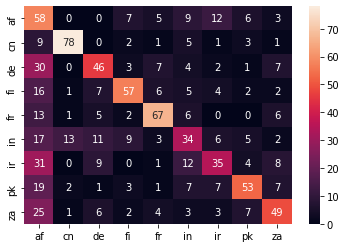

Overall Accuracy: 0.53




Using a discount rate of 0.1
Getting predictions for af
OVR Accuracy for af : 0.49
Getting predictions for cn
OVR Accuracy for cn : 0.86
Getting predictions for de
OVR Accuracy for de : 0.61
Getting predictions for fi
OVR Accuracy for fi : 0.67
Getting predictions for fr
OVR Accuracy for fr : 0.76
Getting predictions for in
OVR Accuracy for in : 0.44
Getting predictions for ir
OVR Accuracy for ir : 0.41
Getting predictions for pk
OVR Accuracy for pk : 0.63
Getting predictions for za
OVR Accuracy for za : 0.63


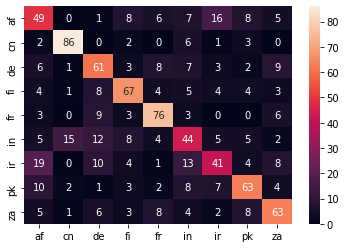

Overall Accuracy: 0.6111111111111112




Using a discount rate of 0.2
Getting predictions for af
OVR Accuracy for af : 0.51
Getting predictions for cn
OVR Accuracy for cn : 0.86
Getting predictions for de
OVR Accuracy for de : 0.64
Getting predictions for fi
OVR Accuracy for fi : 0.67
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.44
Getting predictions for ir
OVR Accuracy for ir : 0.39
Getting predictions for pk
OVR Accuracy for pk : 0.63
Getting predictions for za
OVR Accuracy for za : 0.62


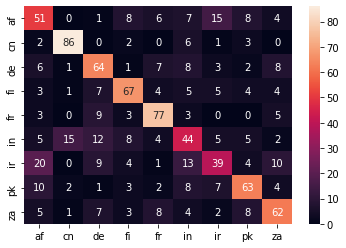

Overall Accuracy: 0.6144444444444445




Using a discount rate of 0.30000000000000004
Getting predictions for af
OVR Accuracy for af : 0.53
Getting predictions for cn
OVR Accuracy for cn : 0.87
Getting predictions for de
OVR Accuracy for de : 0.66
Getting predictions for fi
OVR Accuracy for fi : 0.69
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.44
Getting predictions for ir
OVR Accuracy for ir : 0.4
Getting predictions for pk
OVR Accuracy for pk : 0.63
Getting predictions for za
OVR Accuracy for za : 0.62


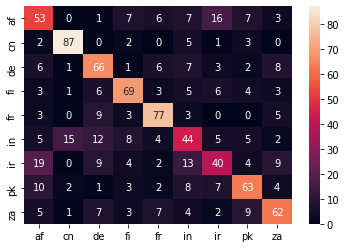

Overall Accuracy: 0.6233333333333333




Using a discount rate of 0.4
Getting predictions for af
OVR Accuracy for af : 0.54
Getting predictions for cn
OVR Accuracy for cn : 0.87
Getting predictions for de
OVR Accuracy for de : 0.67
Getting predictions for fi
OVR Accuracy for fi : 0.7
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.44
Getting predictions for ir
OVR Accuracy for ir : 0.42
Getting predictions for pk
OVR Accuracy for pk : 0.63
Getting predictions for za
OVR Accuracy for za : 0.63


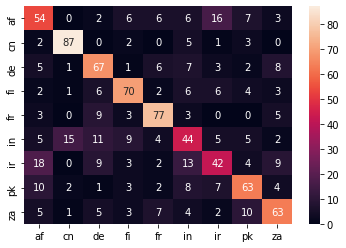

Overall Accuracy: 0.63




Using a discount rate of 0.5
Getting predictions for af
OVR Accuracy for af : 0.54
Getting predictions for cn
OVR Accuracy for cn : 0.88
Getting predictions for de
OVR Accuracy for de : 0.67
Getting predictions for fi
OVR Accuracy for fi : 0.73
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.44
Getting predictions for ir
OVR Accuracy for ir : 0.41
Getting predictions for pk
OVR Accuracy for pk : 0.63
Getting predictions for za
OVR Accuracy for za : 0.63


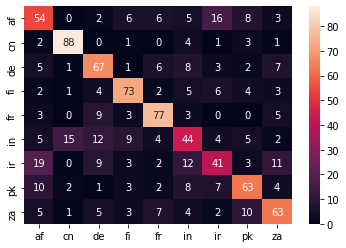

Overall Accuracy: 0.6333333333333333




Using a discount rate of 0.6000000000000001
Getting predictions for af
OVR Accuracy for af : 0.54
Getting predictions for cn
OVR Accuracy for cn : 0.88
Getting predictions for de
OVR Accuracy for de : 0.67
Getting predictions for fi
OVR Accuracy for fi : 0.73
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.45
Getting predictions for ir
OVR Accuracy for ir : 0.4
Getting predictions for pk
OVR Accuracy for pk : 0.64
Getting predictions for za
OVR Accuracy for za : 0.63


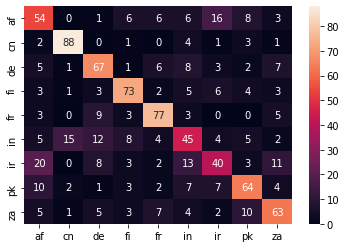

Overall Accuracy: 0.6344444444444445




Using a discount rate of 0.7000000000000001
Getting predictions for af
OVR Accuracy for af : 0.54
Getting predictions for cn
OVR Accuracy for cn : 0.88
Getting predictions for de
OVR Accuracy for de : 0.66
Getting predictions for fi
OVR Accuracy for fi : 0.73
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.44
Getting predictions for ir
OVR Accuracy for ir : 0.39
Getting predictions for pk
OVR Accuracy for pk : 0.64
Getting predictions for za
OVR Accuracy for za : 0.63


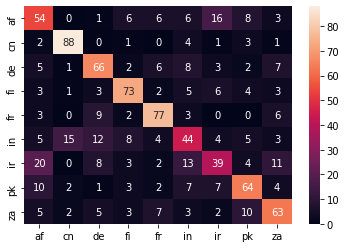

Overall Accuracy: 0.6311111111111111




Using a discount rate of 0.8
Getting predictions for af
OVR Accuracy for af : 0.55
Getting predictions for cn
OVR Accuracy for cn : 0.89
Getting predictions for de
OVR Accuracy for de : 0.68
Getting predictions for fi
OVR Accuracy for fi : 0.74
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.46
Getting predictions for ir
OVR Accuracy for ir : 0.4
Getting predictions for pk
OVR Accuracy for pk : 0.63
Getting predictions for za
OVR Accuracy for za : 0.62


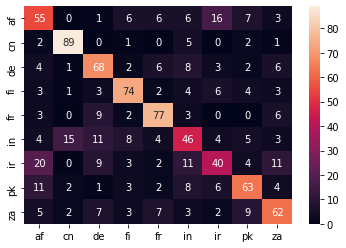

Overall Accuracy: 0.6377777777777778




Using a discount rate of 0.9
Getting predictions for af
OVR Accuracy for af : 0.55
Getting predictions for cn
OVR Accuracy for cn : 0.89
Getting predictions for de
OVR Accuracy for de : 0.67
Getting predictions for fi
OVR Accuracy for fi : 0.74
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.47
Getting predictions for ir
OVR Accuracy for ir : 0.38
Getting predictions for pk
OVR Accuracy for pk : 0.63
Getting predictions for za
OVR Accuracy for za : 0.63


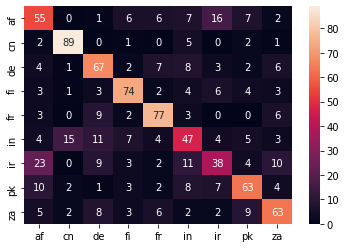

Overall Accuracy: 0.6366666666666667




Using a discount rate of 1.0
Getting predictions for af
OVR Accuracy for af : 0.54
Getting predictions for cn
OVR Accuracy for cn : 0.89
Getting predictions for de
OVR Accuracy for de : 0.67
Getting predictions for fi
OVR Accuracy for fi : 0.74
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.47
Getting predictions for ir
OVR Accuracy for ir : 0.39
Getting predictions for pk
OVR Accuracy for pk : 0.63
Getting predictions for za
OVR Accuracy for za : 0.62


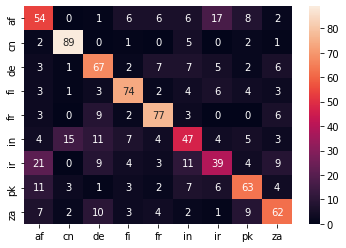

Overall Accuracy: 0.6355555555555555




LOO Maximum Likelihood Discount Rate

Getting Discounts
af will be using a discount of 0.5201808201485308
cn will be using a discount of 0.5518518518518518
de will be using a discount of 0.5331360946745562
fi will be using a discount of 0.5106512477175897
fr will be using a discount of 0.5335820895522388
in will be using a discount of 0.5166798003677436
ir will be using a discount of 0.5326215895610913
pk will be using a discount of 0.5260215053763441
za will be using a discount of 0.5284637379776449
Getting predictions for af
OVR Accuracy for af : 0.54
Getting predictions for cn
OVR Accuracy for cn : 0.88
Getting predictions for de
OVR Accuracy for de : 0.67
Getting predictions for fi
OVR Accuracy for fi : 0.73
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.44
Getting predictions for ir
OVR Accuracy for ir : 0.42
Getting predictions for pk
OVR Accuracy for pk : 0.63
Getting predictions f

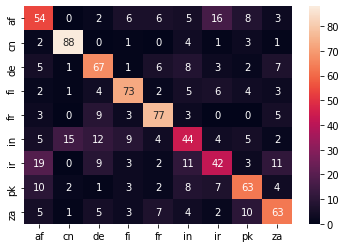

Overall Accuracy: 0.6344444444444445




Using the Kneser-Ney model
Getting predictions for af
OVR Accuracy for af : 0.52
Getting predictions for cn
OVR Accuracy for cn : 0.89
Getting predictions for de
OVR Accuracy for de : 0.69
Getting predictions for fi
OVR Accuracy for fi : 0.8
Getting predictions for fr
OVR Accuracy for fr : 0.77
Getting predictions for in
OVR Accuracy for in : 0.46
Getting predictions for ir
OVR Accuracy for ir : 0.45
Getting predictions for pk
OVR Accuracy for pk : 0.64
Getting predictions for za
OVR Accuracy for za : 0.64


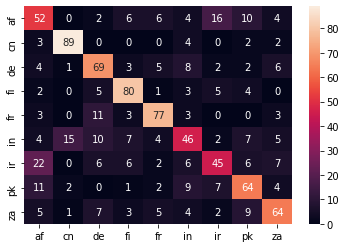

Overall Accuracy: 0.6511111111111111






In [ ]:
#Setting hyperparameters
order = 3
print("Order:",order,'\n')

#Getting model dictionaries which will be used for classification
ad_model_dict = get_ad_model_dict(COUNTRY_CODES,order)
kn_model_dict = get_kn_model_dict(COUNTRY_CODES,order)

#Getting list of discount rates to iterate over
disc_list = list(np.linspace(0,1,11))

#Initializing accuracy dataframe which will be used for visualization later
acc_df = pd.DataFrame(index=list(map(lambda x: str(x)[:3],disc_list))\
                      +['LOO','KN'],
columns=COUNTRY_CODES+['AVG'],
dtype=float)

#Iterating over different classifiers
for disc in disc_list + ['LOO','KN']:

  #Initializing lists used for assessment later
  preds = []
  actual = []

  #Choosing whether to use AD or KN
  if disc == 'KN':
    print("Using the Kneser-Ney model")
    model_dict = kn_model_dict
  else:
    model_dict = ad_model_dict

    #Getting discount rate for AD
    if disc == 'LOO':
      print("LOO Maximum Likelihood Discount Rate")
      disc_dict = get_loo_disc_dict(model_dict,verbose=True)
    else:
      print("Using a discount rate of "+ str(disc))
      disc_dict = dict(zip(COUNTRY_CODES,len(COUNTRY_CODES)*[disc]))
  
  #Iterating over countries
  for country in COUNTRY_CODES:
    
    #Getting all cities in country
    print("Getting predictions for",country)
    with open(VALID_DS_DIR  + '/' + country + '.txt', 
                encoding='utf-8', 
                errors='ignore') as f:
      cities = []
      for line in f:
          cities.append(preprocess_text(line))
      
      #Getting our classifier's prediction
      if disc == 'KN':
        y_pred = get_kn_pred(cities,model_dict)
      else:
        y_pred = get_ad_pred(cities,model_dict,disc_dict)
      
      #Storing our predictions
      preds.extend(y_pred)

      #Getting truth values
      y_true = pd.Series([country] * len(y_pred))

      #Storing truth values
      actual.extend(y_true)
      
      #Getting accuracy score
      acc = accuracy_score(y_true,y_pred)

      #Storing accuracy score
      acc_df.loc[str(disc)[:3],country] = acc
      print("OVR Accuracy for",country,":",acc)

  #Showing confusion matrix heatmap for classifier 
  hmap = pd.DataFrame(confusion_matrix(actual, preds),
                      index=COUNTRY_CODES,
                      columns=COUNTRY_CODES)
  sns.heatmap(hmap, annot=True)
  plt.show()

  #Assessing overall accuracy of classifier and storing it
  avg_acc = accuracy_score(actual, preds)
  acc_df.loc[str(disc)[:3],'AVG'] = avg_acc
  print("Overall Accuracy:",avg_acc)
  print("\n\n\n")

We will now visualize the breakdown of results across models. The different models are represented by the indices: the numbered indices represent AD models with the given discount rate, the LOO represents AD models with the LOO maximum likelihood discount rate, and KN is an imported KneserNey model.

We see that, of my AD models, the maximum overall accuracy is 63.78% when discount=.8 and so we will use discount=.8 for the test set prediction. 

In [ ]:
display(acc_df)

,af,cn,de,fi,fr,in,ir,pk,za,AVG
0.0,0.58,0.78,0.46,0.57,0.67,0.34,0.35,0.53,0.49,0.530000
0.1,0.49,0.86,0.61,0.67,0.76,0.44,0.41,0.63,0.63,0.611111
0.2,0.51,0.86,0.64,0.67,0.77,0.44,0.39,0.63,0.62,0.614444
0.3,0.53,0.87,0.66,0.69,0.77,0.44,0.40,0.63,0.62,0.623333
0.4,0.54,0.87,0.67,0.70,0.77,0.44,0.42,0.63,0.63,0.630000
0.5,0.54,0.88,0.67,0.73,0.77,0.44,0.41,0.63,0.63,0.633333
0.6,0.54,0.88,0.67,0.73,0.77,0.45,0.40,0.64,0.63,0.634444
0.7,0.54,0.88,0.66,0.73,0.77,0.44,0.39,0.64,0.63,0.631111
0.8,0.55,0.89,0.68,0.74,0.77,0.46,0.40,0.63,0.62,0.637778
0.9,0.55,0.89,0.67,0.74,0.77,0.47,0.38,0.63,0.63,0.636667


These are the average accuracies across countries so that we can see how the difficulty of labeling different countries differs.

af     0.537273
cn     0.868182
de     0.641818
fi     0.700909
fr     0.760000
in     0.439091
ir     0.394545
pk     0.622727
za     0.613636
AVG    0.619798
dtype: float64

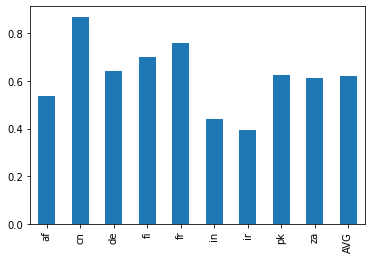

In [ ]:
df = acc_df.iloc[:-2].mean(0)
display(df)
plot = df.plot(kind='bar')
plt.show()

Plotting accuracies for different countries across discount rates. The X-axis is discount rates and the y axis is accuracy.

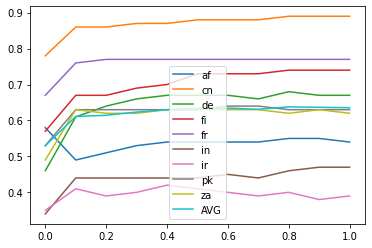

In [ ]:
acc_plot = acc_df.iloc[:-2].plot()
plt.show()

Plotting average accuracy against discount rate. Accuracy is on the y axis and discount rate is on the x axis.

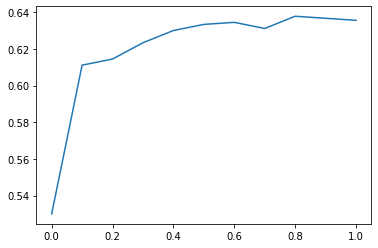

In [ ]:
acc_plot = acc_df.iloc[:-2].mean(1).plot()
plt.show()

Comparing accuracies of the best fixed discount rate of .8, the LOO maximum discount rate and the KneserNey model

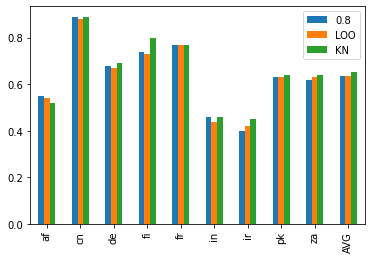

In [ ]:
acc_plot = acc_df.loc[['0.8','LOO','KN']].T.plot(kind='bar')

plt.show()

We choose a discount of .8, and use the absolute discounting models to predict the countries for the test cities.

In [ ]:
model = 3
disc = .8

model_dict = get_ad_model_dict(COUNTRY_CODES,order)
disc_dict = dict(zip(COUNTRY_CODES,len(COUNTRY_CODES)*[disc]))

with open(TEST_DS_PATH, 
            encoding='utf-8', 
            errors='ignore') as f:
  cities = []
  for line in f:
      cities.append(preprocess_text(line))
city_ser = get_ad_pred(cities,model_dict,disc_dict)
for pred in city_ser:
  print(pred)

pk
fi
fi
af
de
fi
za
ir
de
af
in
fi
af
de
fi
za
ir
fr
ir
in
fi
cn
pk
ir
af
fi
de
de
de
ir
pk
fi
cn
pk
fr
cn
ir
fi
de
ir
af
in
za
in
za
af
de
za
cn
cn
fr
za
ir
ir
in
in
in
in
cn
za
fi
pk
de
cn
za
af
fi
af
cn
cn
in
de
cn
pk
cn
de
in
za
ir
ir
in
in
za
af
de
ir
fr
za
za
fr
fi
de
af
cn
fi
cn
in
de
fr
pk
fi
cn
za
fr
za
fr
ir
fr
fr
af
in
fr
za
cn
pk
pk
af
fi
ir
in
cn
de
cn
de
cn
in
pk
pk
cn
de
za
fr
in
cn
pk
pk
fi
de
af
de
za
in
fi
pk
cn
fr
za
za
pk
in
fi
af
af
za
fi
pk
in
fr
af
in
ir
ir
in
za
in
pk
af
af
in
in
af
af
za
cn
pk
ir
de
de
fr
in
fr
za
in
af
za
de
fr
pk
za
za
za
cn
za
fi
in
fr
cn
fr
fi
fi
za
za
pk
fr
za
af
fi
za
af
in
fr
ir
fi
fi
de
de
af
pk
fr
fr
fi
de
cn
af
in
fr
fr
za
cn
af
za
af
ir
cn
de
de
fr
de
de
za
pk
za
ir
pk
ir
fi
af
ir
fr
fi
in
af
de
fi
fi
fr
in
af
fi
de
fi
ir
fi
in
cn
de
af
ir
fr
de
af
fr
fr
de
ir
fi
pk
fr
pk
za
fr
in
de
pk
pk
ir
fi
in
ir
ir
af
pk
af
fr
af
za
de
cn
cn
fr
pk
af
cn
in
ir
de
ir
ir
de
af
fr
cn
de
pk
de
za
pk
cn
cn
fi
za
za
af
za
fi
fr
af
fi
in
ir
ir
ir
fi
p

## **Section 3.2: TODO write a report**

Write a report that describes your model, settings of hyperparameters, the experiments that you ran, and an evaluation of the model's performance. We would like to know what you found works best and why you think it works best. Include a discussion of the testing that you did that convinced you that your results are correct, i.e. your code is suitably bug-free.

You are expected to write an answer containing at least ten sentences of correct and relevant content.





I tested 13 different classifiers: the first 11 used absolute discounting language models (AD LMs) with discounting parameters ranging from 0-1 (increments of .1), the 12th used AD LMs with a leave one out maximum likliehood estimate to obtain discount factors, and the 13th used off-the-shelf imported Kneser–Ney Smoothing language models. For each classifier, I trained 9 language models (one for each country). Then, to obtain a classification for a new city, I would find the perplexity for each model and select the country corresponding to the model with the lowest perplexity.


Of the AD classifiers, the one with the best accuracy was the classifier with a discount rate of .8 which achieved an accuracy of 63.78%. This is fairly good when you consider (1) that there are 9 categories in the classification task and so a random guesser would only achieve 11.11% accuracy (2) the more sophisticated imported KN model achieved a 65.11% accuracy, an increase of only 1.23%. 

We can see from the graph which plots average accuracy agaiinst discount rate that the accuracy shoots up when the discount rate goes from 0 to 0.1 and then slowly increases until it peaks at .8. This means that solely using ngrams of size 3 does not provide a great signal and the ngrams of size 1 and 2 are very useful in the classification task.

When looking at the confusion matrices from training, you'll notice that the biggest source of confusion was between cities in Iran and cities in Afghanistan. This makes sense because they physically border each other and so their city names likely have similar structure.

Also, we see from our plot of average country accuracy that china is consistently the easiest to distinguish from the others with an average accuracy of 86.82% and Iran is the hardest to distinguish from the others with an average accuracy of 39.45%.

I am confident that my code works and is bug free because I trained models on small sample languages and verified that the models accurately represented those languages. Also, my code provided very similar results as the off-the-shelf KN smoothing model. Finally, my many visualizations and print statements along the way allowed me to verify that everything was running smoothly. 